<h1 align='center'>Assignment 5</h1>
<h1 align='center'>Logistic Regression on Donors Choose Dataset</h1>

# Table of Contents
<strong>
1. [Pre-processing](#pre) <br>
   1.1. [Pre-processing of project subject category](#presc) <br>
   1.2. [Pre-processing of project subject sub-category](#prescs) <br>
   1.3. [Text pre-processing](#txtpre) <br>
   1.4. [Preprocessing of Project Grade Category](#prepgc) <br>
   1.5. [Counting the number of words for project_title for SET-5](#countit) <br>
   1.6. [Counting the number of words for project_essay for SET-5](#countess) <br>
   1.7. [Computing Sentiment Score of each essay for SET-5](#ss) <br>
2. [Splitting of data](#split) <br>
3. [Creating data matrix using feature engineering techniques](#feat) <br>
   3.1. [Bag of Words Encoding](#bow) <br>
   3.2. [TFIDF Encoding](#tfidf) <br>
   3.3. [AVG W2V Encoding](#avgw2v) <br>
   3.4. [TFIDF AVG W2V Encoding](#tfidfavgw2v) <br>
4. [One hot encoding of categorical features](#ohe) <br>
   4.1. [One hot encoding of state](#ohes) <br>
   4.2. [One hot encoding of teacher prefix](#ohetp) <br>
   4.3. [One hot encoding of project grade category](#ohepgc) <br>
   4.4. [One hot encoding of project subject category](#ohepsc) <br>
   4.5. [One hot encoding of project subject sub-category](#ohepsc) <br>
5. [Standardizing numerical features](#normal) <br>
   5.1. [Standardizing teacher no. of previously posted projects](#normalppp) <br>
   5.2. [Standardizing price](#normalp) <br>
   5.3. [Standardizing quantity](#normalq) <br>
   5.4. [Standardizing TOTALWORDS_TITLE for SET-5](#normaltwt) <br>
   5.5. [Standardizing TOTALWORDS_ESSAY for SET-5](#normaltwe) <br>
   5.6. [Note for Standardizing SENTIMENT SCORES for SET-5](#note) <br>
6. [Concatinating all features](#merge) <br>
   6.1. [Concatinating features for BoW](#mergebow) <br>
   6.2. [Concatinating features for TFIDF](#mergetfidf) <br>
   6.3. [Concatinating features for AVG W2V](#mergew2v) <br>
   6.4. [Concatinating features for TFIDF AVG W2V](#mergetfidfw2v) <br>
   6.5. [Concatinating features for SET-5](#feat5) <br>
7. [(TASK-1) Applying Logistic Regression](#knn) <br>
   7.1. [Set-1 categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW with bi-grams with min_df=10 and max_features=5000)](#set1) <br>
   7.2. [Set-2 categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF with bi-grams with min_df=10 and max_features=5000)](#set2) <br>
   7.3. [Set-3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_essay (AVG W2V)](#set3) <br>
   7.4. [Set-4: categorical, numerical features + project_title(TFIDF AVG W2V)+ preprocessed_essay (TFIDF AVG W2V)](#set4)<br> 
   7.5. [(TASK-2) Set-5: Applying Logistic Regression WITHOUT TEXT FEATURES (Essay, Project Title and Project Resource Summary)](#set5) 
8. [Conclusion using PrettyTable Library](#conc) <br>

In [ ]:
#importing all the libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [ ]:
#Loading the dataset
project_data  = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')
project_data.head(3)

In [ ]:
#In the values we have considered, we have the division of accepted and rejected as follows.
#It can be said that it is an imbalanced dataset
project_data['project_is_approved'].value_counts()

In [ ]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [ ]:
print("Summary of Data: ", project_data.info())

In [ ]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

project_data.head(2)

# 1. Pre-processing
<a id='pre'></a>

### 1.1 Preprocessing of project subject category
<a id='presc'></a>

In [ ]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### 1.2 Preprocessing of project subject sub-category
<a id='prescs'></a>

In [ ]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.3 Text - preprocessing
<a id='txtpre'></a>

In [ ]:
#Pre processing of essay.
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [ ]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

In [ ]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

In [ ]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

In [ ]:
#preprocessing of project title.
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_title.append(sent.lower().strip())

In [ ]:
#teacher prefix contains null values.
project_data["teacher_prefix"].fillna("null", inplace = True)

In [ ]:
#Replacing actual column values with the preprocessed ones.
project_data['project_title'] = preprocessed_title
project_data['essay'] = preprocessed_essays

In [ ]:
#Since we have summed essay into one. We dont need 4 essays. 
#Citation: pandas drop a column
#url: https://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe-by-column-name
columns = ['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4']
project_data.drop(columns, axis=1, inplace=True)

In [ ]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data

In [ ]:
X.head(2)

### 1. 4. Preprocessing of Project Grade Category.

<a id='prepgc'></a>

In [ ]:
#As you can see we have four categories.
#While vectorizing this we get 'grades' separately. That is,
#Prek-2, 3-5, 6-8, 9-12, Grades -> We get 5 categories which is wrong. Hence rectifying it

X['project_grade_category'].value_counts()

In [ ]:
#We will replace the value of Grades Prek-2 with Grades-Prek-2
#And subsequently for other categories.

grade = X['project_grade_category']

In [ ]:
#Citation
#url: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html

grade.replace('Grades PreK-2', 'Grades-PreK-2', inplace=True)
grade.replace('Grades 3-5', 'Grades-3-5', inplace=True)
grade.replace('Grades 6-8', 'Grades-6-8', inplace=True)
grade.replace('Grades 9-12', 'Grades-9-12', inplace=True)

In [ ]:
#Assigning new grades with to the column
grade.head()

In [ ]:
X['project_grade_category'] = grade

### 1. 5. Counting the number of words for project_title for SET-5

<a id='countit'></a>

In [ ]:
#Counting the number of words in project_title for SET-5

#Citation: calculate number of words in text dataframe
#url: https://stackoverflow.com/questions/49984905/count-number-of-words-per-row
X['totalwords_title'] = X['project_title'].str.split().str.len()

### 1. 6. Counting the number of words for project_essay for SET-5

<a id='countess'></a>

In [ ]:
#Counting the number of words in essay for SET-5

#Citation: calculate number of words in text dataframe
#url: https://stackoverflow.com/questions/49984905/count-number-of-words-per-row
X['totalwords_essay'] = X['essay'].str.split().str.len()

### 1. 7. Computing Sentiment Score of each essay for SET-5

<a id='ss'></a>

In [ ]:
#Citation: store sentiment score in dataframe
#https://stackoverflow.com/questions/46764674/sentiment-analysis-on-dataframe
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

abc = X['essay'].apply(lambda Text: sid.polarity_scores(Text))

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

In [ ]:
#We can see that it returns a dictionary (key-value pairs). Therefore we will convert Series to dict 
type(abc)

In [ ]:
final = abc.to_dict()

In [ ]:
#What we have here is a Series, converting series to Pandas dataframe using from_dict() method
type(final)

In [ ]:
final2 = pd.DataFrame.from_dict(final)

In [ ]:
#We will need to transpose the DataFrame to get negative, positive etc values in the column region.
final2.head()

In [ ]:
final2 = final2.T

In [ ]:
#This is the proper DataFrame.
final2.head()

In [ ]:
#Adding these values to our mail Dataframe.
X['Compound Score'] = final2['compound']
X['Negative Score'] = final2['neg']
X['Neutral Score'] = final2['neu']
X['Positive Score'] = final2['pos']

In [ ]:
#Final dataframe
X.head()

# 2. Splitting the Data

<a id='split'></a>

In [40]:
# train test split before vectorizing or performing any feature engineering techniques
#as doing it before leads to data leakage.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# 3. Creating Data Matrix using Feature Engineering Techniques.

<a id='feat'></a>

### 3.1 Bag Of Words Encoding

<a id='bow'></a>

In [41]:
%%time
#BoW for essay.
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer

#As stated in the assignment
#I have taken min_df=10
#Bi-gram: That is, ngram_range=(1,2) and max features=5000
vectorizer_essay = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer_essay.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_essay.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer_essay.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

(49041, 21) (49041,)
(24155, 21) (24155,)
(36052, 21) (36052,)
After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)
Wall time: 1min 53s


In [42]:
%%time
#BoW for project-title.
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer

#As stated in the assignment
#I have taken min_df=10
#Bi-gram: That is, ngram_range=(1,2) and max features=5000
vectorizer_title = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer_title.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer_title.transform(X_train['project_title'].values)
X_cv_title_bow = vectorizer_title.transform(X_cv['project_title'].values)
X_test_title_bow = vectorizer_title.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)

(49041, 21) (49041,)
(24155, 21) (24155,)
(36052, 21) (36052,)
After vectorizations
(49041, 3253) (49041,)
(24155, 3253) (24155,)
(36052, 3253) (36052,)
Wall time: 5.87 s


In [43]:
#BoW for project-resource-summary
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer

#As stated in the assignment
#I have taken min_df=10
#Bi-gram: That is, ngram_range=(1,2) and max features=5000

vectorizer_resum = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer_resum.fit(X_train['project_resource_summary'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_resum_bow = vectorizer_resum.transform(X_train['project_resource_summary'].values)
X_cv_resum_bow = vectorizer_resum.transform(X_cv['project_resource_summary'].values)
X_test_resum_bow = vectorizer_resum.transform(X_test['project_resource_summary'].values)

print("After vectorizations")
print(X_train_resum_bow.shape, y_train.shape)
print(X_cv_resum_bow.shape, y_cv.shape)
print(X_test_resum_bow.shape, y_test.shape)

(49041, 21) (49041,)
(24155, 21) (24155,)
(36052, 21) (36052,)
After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


### 3.2 TF-IDF Encoding

<a id='tfidf'></a>

In [64]:
#TF-IDF Encoding on project essay
from sklearn.feature_extraction.text import TfidfVectorizer

#As stated in the assignment
#I have taken min_df=10
#Bi-gram: That is, ngram_range=(1,2) and max features=5000

vectorizer_essay_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=5000)
vectorizer_essay_tfidf.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_essay_tfidf.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer_essay_tfidf.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer_essay_tfidf.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


In [65]:
#TF-IDF Encoding on project title
from sklearn.feature_extraction.text import TfidfVectorizer

#As stated in the assignment
#I have taken min_df=10
#Bi-gram: That is, ngram_range=(1,2) and max features=5000

vectorizer_title_tfidf = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer_title_tfidf.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer_title_tfidf.transform(X_train['project_title'].values)
X_cv_title_tfidf = vectorizer_title_tfidf.transform(X_cv['project_title'].values)
X_test_title_tfidf = vectorizer_title_tfidf.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

After vectorizations
(49041, 3253) (49041,)
(24155, 3253) (24155,)
(36052, 3253) (36052,)


In [66]:
#TF-IDF Encoding on project res summary

from sklearn.feature_extraction.text import TfidfVectorizer

#As stated in the assignment
#I have taken min_df=10
#Bi-gram: That is, ngram_range=(1,2) and max features=5000

vectorizer_resum_tfidf = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer_resum_tfidf.fit(X_train['project_resource_summary'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_resum_tfidf = vectorizer_title_tfidf.transform(X_train['project_resource_summary'].values)
X_cv_resum_tfidf = vectorizer_title_tfidf.transform(X_cv['project_resource_summary'].values)
X_test_resum_tfidf = vectorizer_title_tfidf.transform(X_test['project_resource_summary'].values)

print("After vectorizations")
print(X_train_resum_tfidf.shape, y_train.shape)
print(X_cv_resum_tfidf.shape, y_cv.shape)
print(X_test_resum_tfidf.shape, y_test.shape)

After vectorizations
(49041, 3253) (49041,)
(24155, 3253) (24155,)
(36052, 3253) (36052,)


### 3.3 AVG W2V Encoding

<a id='avgw2v'></a>

In [71]:
#ON PRE-PROCESSED ESSAY
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    
#Train part of preprocessed essays.
train_w2v_vectors_essays = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_w2v_vectors_essays.append(vector)
print("Train Vector for essay")
print(len(train_w2v_vectors_essays))
print(len(train_w2v_vectors_essays[0]))

#Test part of preprocessed essays.
# average Word2Vec
# compute average word2vec for each review.
test_w2v_vectors_essays = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_w2v_vectors_essays.append(vector)

print("Test Vector for essay")
print(len(test_w2v_vectors_essays))
print(len(test_w2v_vectors_essays[0]))

#CV part of preprocessed essays.
# average Word2Vec
# compute average word2vec for each review.
cv_w2v_vectors_essays = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_cv['essay'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_w2v_vectors_essays.append(vector)

print("CV vector for essay")
print(len(cv_w2v_vectors_essays))
print(len(cv_w2v_vectors_essays[0]))

# Changing the lists (Train, Test, CV) to numpy arrays
train_w2v_vectors_essays = np.array(train_w2v_vectors_essays)
test_w2v_vectors_essays = np.array(test_w2v_vectors_essays)
cv_w2v_vectors_essays = np.array(cv_w2v_vectors_essays)

100%|██████████| 49041/49041 [00:37<00:00, 1291.15it/s]


Train Vector for essay
49041
300


100%|██████████| 36052/36052 [00:27<00:00, 1315.87it/s]


Test Vector for essay
36052
300


100%|██████████| 24155/24155 [00:18<00:00, 1335.18it/s]


CV vector for essay
24155
300


In [72]:
#Following the same process for preprocessed titles.
# average Word2Vec
# compute average word2vec for each review.
w2v_train_vectors_titles = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_train['project_title'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_train_vectors_titles.append(vector)
print("Train Vector for project title")
print(len(w2v_train_vectors_titles))
print(len(w2v_train_vectors_titles[0]))

# average Word2Vec
# compute average word2vec for each review.
w2v_test_vectors_titles = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_test['project_title'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_test_vectors_titles.append(vector)

print("Test Vector for project title")
print(len(w2v_test_vectors_titles))
print(len(w2v_test_vectors_titles[0]))

# average Word2Vec
# compute average word2vec for each review.
w2v_cv_vectors_titles = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_cv['project_title'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_cv_vectors_titles.append(vector)

print("CV Vector for project title")
print(len(w2v_cv_vectors_titles))
print(len(w2v_cv_vectors_titles[0]))

100%|██████████| 49041/49041 [00:01<00:00, 27725.09it/s]


Train Vector for project title
49041
300


100%|██████████| 36052/36052 [00:01<00:00, 26063.85it/s]


Test Vector for project title
36052
300


100%|██████████| 24155/24155 [00:00<00:00, 24990.64it/s]


CV Vector for project title
24155
300


In [73]:
# Changing the lists (Train, Test, CV) to numpy arrays
w2v_train_vectors_titles = np.array(w2v_train_vectors_titles)
w2v_test_vectors_titles = np.array(w2v_test_vectors_titles)
w2v_cv_vectors_titles = np.array(w2v_cv_vectors_titles)

In [74]:
#Following the same process for project resource summary.
# average Word2Vec
# compute average word2vec for each review.
w2v_train_vectors_resum = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_train['project_resource_summary'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_train_vectors_resum.append(vector)
print("Train Vector for project resource summary")
print(len(w2v_train_vectors_resum))
print(len(w2v_train_vectors_resum[0]))

# average Word2Vec
# compute average word2vec for each review.
w2v_test_vectors_resum = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_test['project_resource_summary'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_test_vectors_resum.append(vector)

print("Test Vector for project resource summary")
print(len(w2v_test_vectors_resum))
print(len(w2v_test_vectors_resum[0]))

# average Word2Vec
# compute average word2vec for each review.
w2v_cv_vectors_resum = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_cv['project_resource_summary'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_cv_vectors_resum.append(vector)

print("CV Vector for project resource summary")
print(len(w2v_cv_vectors_resum))
print(len(w2v_cv_vectors_resum[0]))

100%|██████████| 49041/49041 [00:05<00:00, 9231.65it/s] 


Train Vector for project resource summary
49041
300


100%|██████████| 36052/36052 [00:03<00:00, 10307.86it/s]


Test Vector for project resource summary
36052
300


100%|██████████| 24155/24155 [00:02<00:00, 10245.17it/s]


CV Vector for project resource summary
24155
300


In [75]:
# Changing the lists (Train, Test, CV) to numpy arrays
w2v_train_vectors_resum = np.array(w2v_train_vectors_resum)
w2v_test_vectors_resum = np.array(w2v_test_vectors_resum)
w2v_cv_vectors_resum = np.array(w2v_cv_vectors_resum)

### 3.4 TFIDF AVG W2V Encoding

<a id='tfidfavgw2v'></a>

In [84]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [85]:
#ON PRE-PROCESSED ESSAY
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

train_tfidf_w2v_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_essay.append(vector)

print(len(train_tfidf_w2v_essay))
print(len(train_tfidf_w2v_essay[0]))

cv_tfidf_w2v_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_essay.append(vector)

print(len(cv_tfidf_w2v_essay))
print(len(cv_tfidf_w2v_essay[0]))

test_tfidf_w2v_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_essay.append(vector)

print(len(test_tfidf_w2v_essay))
print(len(test_tfidf_w2v_essay[0]))

# Changing list to numpy arrays
train_tfidf_w2v_essay = np.array(train_tfidf_w2v_essay)
test_tfidf_w2v_essay = np.array(test_tfidf_w2v_essay)
cv_tfidf_w2v_essay = np.array(cv_tfidf_w2v_essay)

100%|██████████| 49041/49041 [04:20<00:00, 188.57it/s]


49041
300


100%|██████████| 24155/24155 [01:57<00:00, 206.36it/s]


24155
300


100%|██████████| 36052/36052 [02:59<00:00, 200.85it/s]


36052
300


In [86]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_title)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

#ON PREPROCESSED TITLE
train_tfidf_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_title.append(vector)

print(len(train_tfidf_w2v_title))
print(len(train_tfidf_w2v_title[0]))

cv_tfidf_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_title.append(vector)

print(len(cv_tfidf_w2v_title))
print(len(cv_tfidf_w2v_title[0]))

test_tfidf_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_title.append(vector)

print(len(test_tfidf_w2v_title))
print(len(test_tfidf_w2v_title[0]))

# Changing list to numpy arrays
train_tfidf_w2v_title = np.array(train_tfidf_w2v_title)
test_tfidf_w2v_title = np.array(test_tfidf_w2v_title)
cv_tfidf_w2v_title = np.array(cv_tfidf_w2v_title)

100%|██████████| 49041/49041 [00:04<00:00, 11756.14it/s]


49041
300


100%|██████████| 24155/24155 [00:02<00:00, 11492.19it/s]


24155
300


100%|██████████| 36052/36052 [00:03<00:00, 9574.69it/s] 


36052
300


In [87]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X['project_resource_summary'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [88]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

#ON PREPROCESSED TITLE
train_tfidf_w2v_resum = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_resource_summary']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_resum.append(vector)

print(len(train_tfidf_w2v_resum))
print(len(train_tfidf_w2v_resum[0]))

cv_tfidf_w2v_resum = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['project_resource_summary']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_resum.append(vector)

print(len(cv_tfidf_w2v_resum))
print(len(cv_tfidf_w2v_resum[0]))

test_tfidf_w2v_resum = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_resource_summary']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_resum.append(vector)

print(len(test_tfidf_w2v_resum))
print(len(test_tfidf_w2v_resum[0]))

# Changing list to numpy arrays
train_tfidf_w2v_resum = np.array(train_tfidf_w2v_resum)
test_tfidf_w2v_resum = np.array(test_tfidf_w2v_resum)
cv_tfidf_w2v_resum = np.array(cv_tfidf_w2v_resum)

100%|██████████| 49041/49041 [00:15<00:00, 3067.98it/s]


49041
300


100%|██████████| 24155/24155 [00:07<00:00, 3166.00it/s]


24155
300


100%|██████████| 36052/36052 [00:12<00:00, 2891.46it/s]


36052
300


# 4. One Hot Encoding of Categorical features. 
<a id='ohe'></a>

### 4.1 One Hot Encoding of STATE.
<a id='ohes'></a>

In [44]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### 4.2 One Hot Encoding of TEACHER-PREFIX.
### NOTE:- Teacher prefix contains 2 null values and OHE cannot be performed on NaN values. Hence I have filled the two NaN values using fllna() with 'null'

<a id='ohetp'></a>

In [45]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 6) (49041,)
(24155, 6) (24155,)
(36052, 6) (36052,)
['dr', 'mr', 'mrs', 'ms', 'null', 'teacher']


### 4.3 One Hot Encoding of PROJECT_GRADE_CATEGORY.

<a id='ohepgc'></a>

In [46]:
from collections import Counter
Counter = Counter()
for word in X_train['project_grade_category'].values:
    Counter.update(word.split())

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
project_grade_category_dict = dict(Counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

In [47]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['Grades-9-12', 'Grades-6-8', 'Grades-3-5', 'Grades-PreK-2']


### 4.4 One Hot Encoding of PROJECT SUBJECT CATEGORY

<a id='ohepsc'></a>

In [48]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_cat_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_cat_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_cat_ohe.shape, y_train.shape)
print(X_cv_clean_cat_ohe.shape, y_cv.shape)
print(X_test_clean_cat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


### 4.5 One Hot Encoding of PROJECT SUBJECT SUB-CATEGORY

<a id='ohepssc'></a>

In [49]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcat_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcat_ohe.shape, y_train.shape)
print(X_cv_clean_subcat_ohe.shape, y_cv.shape)
print(X_test_clean_subcat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


# 5. Standardizing numerical features 
<a id='normal'></a>

### 5.1 Standardizing TEACHER NO OF PREV. POSTED PROJ
<a id='normalppp'></a>

In [50]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
standard_vec = StandardScaler()

standard_vec.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_TNPPP_std = standard_vec.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_TNPP_std = standard_vec.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_TNPP_std = standard_vec.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_TNPPP_std.shape, y_train.shape)
print(X_cv_TNPP_std.shape, y_cv.shape)
print(X_test_TNPP_std.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 5.2 Standardizing PRICE
<a id='normalp'></a>

In [51]:
from sklearn.preprocessing import StandardScaler
standard_vec = StandardScaler()

standard_vec.fit(X_train['price'].values.reshape(-1,1))

X_train_price_std = standard_vec.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_std = standard_vec.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_std = standard_vec.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_std.shape, y_train.shape)
print(X_cv_price_std.shape, y_cv.shape)
print(X_test_price_std.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 5.3 Standardizing QUANTITY
<a id='normalq'></a>

In [52]:
from sklearn.preprocessing import StandardScaler
standard_vec = StandardScaler()

standard_vec.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_std = standard_vec.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_std = standard_vec.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_std = standard_vec.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_std.shape, y_train.shape)
print(X_cv_quantity_std.shape, y_cv.shape)
print(X_test_quantity_std.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 5.4 Standardizing TOTALWORDS_TITLE for SET-5
<a id='normaltwt'></a>

In [53]:
#Standardizing totalwords as its a numerical feature.
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
standard_vec = StandardScaler()

standard_vec.fit(X_train['totalwords_title'].values.reshape(-1,1))

X_train_titlecount_std = standard_vec.transform(X_train['totalwords_title'].values.reshape(-1,1))
X_cv_titlecount_std = standard_vec.transform(X_cv['totalwords_title'].values.reshape(-1,1))
X_test_titlecount_std = standard_vec.transform(X_test['totalwords_title'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_titlecount_std.shape, y_train.shape)
print(X_cv_titlecount_std.shape, y_cv.shape)
print(X_test_titlecount_std.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 5.5 Standardizing TOTALWORDS_ESSAY for SET-5
<a id='normaltwe'></a>

In [54]:
#Standardizing totalwords as its a numerical feature.
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
standard_vec = StandardScaler()

standard_vec.fit(X_train['totalwords_essay'].values.reshape(-1,1))

X_train_essaycount_std = standard_vec.transform(X_train['totalwords_essay'].values.reshape(-1,1))
X_cv_essaycount_std = standard_vec.transform(X_cv['totalwords_essay'].values.reshape(-1,1))
X_test_essaycount_std = standard_vec.transform(X_test['totalwords_essay'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_essaycount_std.shape, y_train.shape)
print(X_cv_essaycount_std.shape, y_cv.shape)
print(X_test_essaycount_std.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


## NOTE:  We don't need to Standardize the Sentiment scores as they are probabilities between 0 and 1. Therefore I will just convert those column values to an array.

<a id='note'></a>

In [55]:
#Compound Score Array
#You can either do reshape(-1, 1) or <variable_name>.T to transpose your array. I have chosen reshape(-1, 1)

X_train_compsc = np.array([X_train['Compound Score']]).reshape(-1, 1)
X_cv_compsc = np.array([X_cv['Compound Score']]).reshape(-1, 1)
X_test_compsc = np.array([X_test['Compound Score']]).reshape(-1, 1)

In [56]:
#Neutral Score Array
X_train_neusc = np.array([X_train['Neutral Score']]).reshape(-1, 1)
X_cv_neusc = np.array([X_cv['Neutral Score']]).reshape(-1, 1)
X_test_neusc = np.array([X_test['Neutral Score']]).reshape(-1, 1)

In [57]:
#Negative Score Array
X_train_negsc = np.array([X_train['Negative Score']]).reshape(-1, 1)
X_cv_negsc = np.array([X_cv['Negative Score']]).reshape(-1, 1)
X_test_negsc = np.array([X_test['Negative Score']]).reshape(-1, 1)

In [58]:
#Positive Score Array
X_train_possc = np.array([X_train['Positive Score']]).reshape(-1, 1)
X_cv_possc = np.array([X_cv['Positive Score']]).reshape(-1, 1)
X_test_possc = np.array([X_test['Positive Score']]).reshape(-1, 1)

# 6. Concatinating All Features.
<a id='merge'></a>

### 6. 1 Concatinating for BoW

<a id='mergebow'></a>

In [59]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#Concatinating features for BoW
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_title_bow, X_train_resum_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_clean_cat_ohe, X_train_clean_subcat_ohe, X_train_TNPPP_std, X_train_price_std, X_train_quantity_std)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_title_bow, X_cv_resum_bow, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_clean_cat_ohe, X_cv_clean_subcat_ohe, X_cv_TNPP_std, X_cv_price_std, X_cv_quantity_std)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_title_bow, X_test_resum_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_clean_cat_ohe, X_test_clean_subcat_ohe, X_test_TNPP_std, X_test_price_std, X_test_quantity_std)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 13356) (49041,)
(24155, 13356) (24155,)
(36052, 13356) (36052,)


### 6. 2 Concatinating for TF-IDF
<a id='mergetfidf'></a>

In [67]:
#Concatinating features for TFIDF
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf, X_train_title_tfidf, X_train_resum_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_clean_cat_ohe, X_train_clean_subcat_ohe, X_train_TNPPP_std, X_train_price_std, X_train_quantity_std)).tocsr()
X_cr = hstack((X_cv_essay_tfidf, X_cv_title_tfidf, X_cv_resum_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_clean_cat_ohe, X_cv_clean_subcat_ohe, X_cv_TNPP_std, X_cv_price_std, X_cv_quantity_std)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_title_tfidf, X_test_resum_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_clean_cat_ohe, X_test_clean_subcat_ohe, X_test_TNPP_std, X_test_price_std, X_test_quantity_std)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 11609) (49041,)
(24155, 11609) (24155,)
(36052, 11609) (36052,)


### 6. 3 Concatinating for AVG W2V
<a id='mergew2v'></a>

In [76]:
#Concatinating features for AVG W2V
from scipy.sparse import hstack
X_tr = hstack((train_w2v_vectors_essays, w2v_train_vectors_titles, w2v_train_vectors_resum, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_clean_cat_ohe, X_train_clean_subcat_ohe, X_train_TNPPP_std, X_train_price_std, X_train_quantity_std)).tocsr()
X_cr = hstack((cv_w2v_vectors_essays, w2v_cv_vectors_titles, w2v_cv_vectors_resum, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_clean_cat_ohe, X_cv_clean_subcat_ohe, X_cv_TNPP_std, X_cv_price_std, X_cv_quantity_std)).tocsr()
X_te = hstack((test_w2v_vectors_essays, w2v_test_vectors_titles, w2v_test_vectors_resum, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_clean_cat_ohe, X_test_clean_subcat_ohe, X_test_TNPP_std, X_test_price_std, X_test_quantity_std)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 1003) (49041,)
(24155, 1003) (24155,)
(36052, 1003) (36052,)


### 6.4 Concatinating for TFIDF AVG W2V
<a id='mergetfidfw2v'></a>

In [89]:
#Concatinating features for TFIDF W2V
from scipy.sparse import hstack
X_tr = hstack((train_tfidf_w2v_essay, train_tfidf_w2v_title, train_tfidf_w2v_resum, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_clean_cat_ohe, X_train_clean_subcat_ohe, X_train_TNPPP_std, X_train_price_std, X_train_quantity_std)).tocsr()
X_cr = hstack((cv_tfidf_w2v_essay, cv_tfidf_w2v_title, cv_tfidf_w2v_resum, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_clean_cat_ohe, X_cv_clean_subcat_ohe, X_cv_TNPP_std, X_cv_price_std, X_cv_quantity_std)).tocsr()
X_te = hstack((test_tfidf_w2v_essay, test_tfidf_w2v_title, test_tfidf_w2v_resum, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_clean_cat_ohe, X_test_clean_subcat_ohe, X_test_TNPP_std, X_test_price_std, X_test_quantity_std)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 1003) (49041,)
(24155, 1003) (24155,)
(36052, 1003) (36052,)


### 6. 5 Concatinating features for SET-5
<a id='feat5'></a>

In [95]:
#Concatinating features for TFIDF W2V
from scipy.sparse import hstack
X_tr = hstack((X_train_titlecount_std, X_train_essaycount_std, X_train_compsc, X_train_neusc, X_train_negsc, X_train_possc, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_clean_cat_ohe, X_train_clean_subcat_ohe, X_train_TNPPP_std, X_train_price_std, X_train_quantity_std)).tocsr()
X_cr = hstack((X_cv_titlecount_std, X_cv_essaycount_std, X_cv_compsc, X_cv_neusc, X_cv_negsc, X_cv_possc, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_clean_cat_ohe, X_cv_clean_subcat_ohe, X_cv_TNPP_std, X_cv_price_std, X_cv_quantity_std)).tocsr()
X_te = hstack((X_test_titlecount_std, X_test_essaycount_std, X_test_compsc, X_test_neusc, X_test_negsc, X_test_possc, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_clean_cat_ohe, X_test_clean_subcat_ohe, X_test_TNPP_std, X_test_price_std, X_test_quantity_std)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 109) (49041,)
(24155, 109) (24155,)
(36052, 109) (36052,)


# 7. Applying Logistic Regression

<a id='knn'></a>

## Set-1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW with bi-grams with min_df=10 and max_features=5000
<a id='set1'></a>

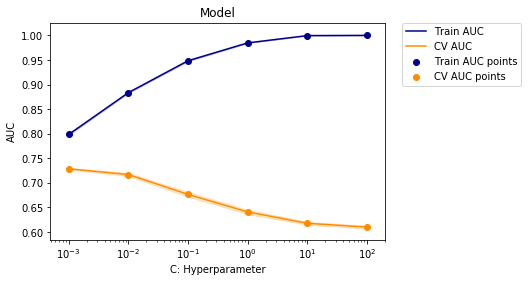

In [60]:
#Citation:
#This code is copied from here: https://stackoverflow.com/a/48803361/4084039

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, class_weight='balanced')

param_grid = {
    
    'C': np.logspace(-3, 2, 6)
}

grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc')
                    
grid.fit(X_tr, y_train)

Cs = np.logspace(-3, 2, 6)

train_auc = grid.cv_results_["mean_train_score"]
train_scores_std = grid.cv_results_["std_train_score"]
cv_auc = grid.cv_results_["mean_test_score"]
cv_scores_std = grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Model')
plt.xlabel('C: Hyperparameter')
plt.ylabel('AUC')

# plot train scores
plt.semilogx(Cs, train_auc, label='Train AUC', color='darkblue')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       train_auc - train_scores_std,
                       train_auc + train_scores_std,
                       alpha=0.2,
                       color='darkblue')

plt.semilogx(Cs, cv_auc, label='CV AUC', color='darkorange')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       cv_auc - cv_scores_std,
                       cv_auc + cv_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.scatter(Cs, train_auc, label='Train AUC points', color='darkblue')
plt.scatter(Cs, cv_auc, label='CV AUC points', color='darkorange')

#Citation for plotting the legend outside the plot
#url: https://matplotlib.org/users/legend_guide.html

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

AUC of Train Data: 0.79
AUC of Test Data: 0.73


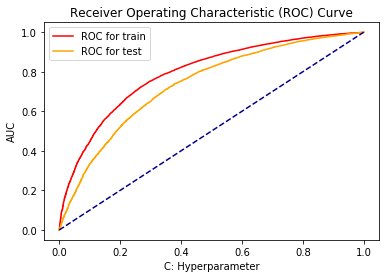

Wall time: 4.93 s


In [61]:
%%time

#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/

best_C = 0.001

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

model_bow = LogisticRegression(C=best_C, random_state=0, class_weight='balanced')
model_bow.fit(X_tr, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('C: Hyperparameter')
    plt.ylabel('AUC')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = model_bow.predict_log_proba(X_te)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = model_bow.predict_log_proba(X_tr)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.2f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.2f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [62]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold -0.921


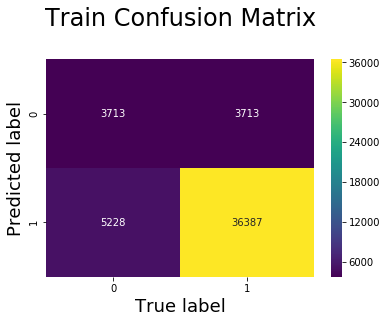

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold -0.846


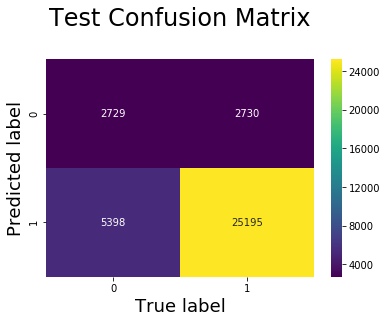

In [63]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## Set-2 categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF with bi-grams with min_df=10 and max_features=5000

<a id='set2'></a>

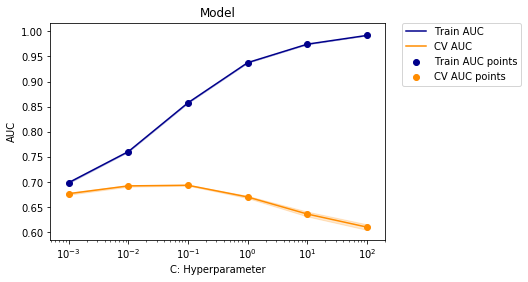

In [68]:
#Citation:
#This code is copied from here: https://stackoverflow.com/a/48803361/4084039

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model_tfidf = LogisticRegression(random_state=0, class_weight='balanced')

#to plot the graph properly I used logspace. 
#The below code (-3, 2, 6) means 10^-3 to 10^2 with 6 values, That is
#0.001, 0.01, 0.1, 1, 10, 100 -> 6 values. Default base is 10 for logspace.

param_grid = {
    
    'C': np.logspace(-3, 2, 6)
}

grid = GridSearchCV(model_tfidf, param_grid, cv=3, scoring='roc_auc')
                    
grid.fit(X_tr, y_train)

Cs = np.logspace(-3, 2, 6)

train_auc = grid.cv_results_["mean_train_score"]
train_scores_std = grid.cv_results_["std_train_score"]
cv_auc = grid.cv_results_["mean_test_score"]
cv_scores_std = grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Model')
plt.xlabel('C: Hyperparameter')
plt.ylabel('AUC')

# plot train scores
#Make a plot with log scaling on the x axis I used semilogx.

plt.semilogx(Cs, train_auc, label='Train AUC', color='darkblue')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       train_auc - train_scores_std,
                       train_auc + train_scores_std,
                       alpha=0.2,
                       color='darkblue')

plt.semilogx(Cs, cv_auc, label='CV AUC', color='darkorange')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       cv_auc - cv_scores_std,
                       cv_auc + cv_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.scatter(Cs, train_auc, label='Train AUC points', color='darkblue')
plt.scatter(Cs, cv_auc, label='CV AUC points', color='darkorange')

#Citation for plotting the legend outside the plot
#url: https://matplotlib.org/users/legend_guide.html

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [69]:
print("Best parameters: ", grid.best_params_)

Best parameters:  {'C': 0.1}


AUC of Train Data: 0.84
AUC of Test Data: 0.70


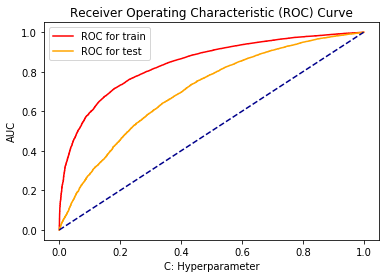

Wall time: 12.3 s


In [70]:
%%time

#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/

best_C = 0.1

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

model_tfidf = LogisticRegression(C = best_C, random_state=0, class_weight='balanced')
model_tfidf.fit(X_tr, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('C: Hyperparameter')
    plt.ylabel('AUC')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = model_tfidf.predict_log_proba(X_te)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = model_tfidf.predict_log_proba(X_tr)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.2f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.2f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [64]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999818661462 for threshold -0.835


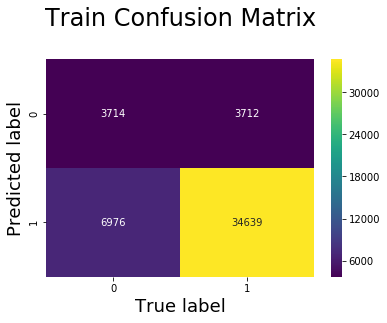

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold -0.784


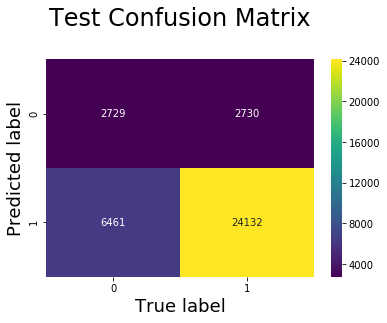

In [65]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_essay (AVG W2V)

<a id='set3'></a>

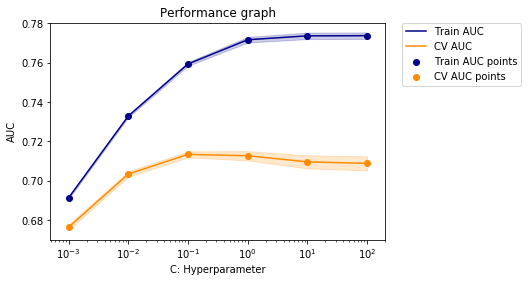

Wall time: 28min 11s


In [79]:
%%time

#Citation:
#This code is copied from here: https://stackoverflow.com/a/48803361/4084039

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model_avgw2v = LogisticRegression(random_state=0, class_weight='balanced')

#to plot the graph properly I used logspace. 
#The below code (-3, 2, 6) means 10^-3 to 10^2 with 6 values, That is
#0.001, 0.01, 0.1, 1, 10, 100 -> 6 values. Default base is 10 for logspace.

param_grid = {
    
    'C': np.logspace(-3, 2, 6)
}

grid = GridSearchCV(model_avgw2v, param_grid, cv=3, scoring='roc_auc')
                    
grid.fit(X_tr, y_train)

Cs = np.logspace(-3, 2, 6)

train_auc = grid.cv_results_["mean_train_score"]
train_scores_std = grid.cv_results_["std_train_score"]
cv_auc = grid.cv_results_["mean_test_score"]
cv_scores_std = grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Performance graph')
plt.xlabel('C: Hyperparameter')
plt.ylabel('AUC')

# plot train scores
#Make a plot with log scaling on the x axis I used semilogx.

plt.semilogx(Cs, train_auc, label='Train AUC', color='darkblue')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       train_auc - train_scores_std,
                       train_auc + train_scores_std,
                       alpha=0.2,
                       color='darkblue')

plt.semilogx(Cs, cv_auc, label='CV AUC', color='darkorange')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       cv_auc - cv_scores_std,
                       cv_auc + cv_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.scatter(Cs, train_auc, label='Train AUC points', color='darkblue')
plt.scatter(Cs, cv_auc, label='CV AUC points', color='darkorange')

#Citation for plotting the legend outside the plot
#url: https://matplotlib.org/users/legend_guide.html

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [80]:
print("Best parameters: ", grid.best_params_)

Best parameters:  {'C': 0.1}


AUC of Train Data: 0.75
AUC of Test Data: 0.72


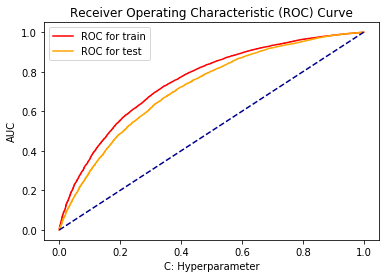

Wall time: 53.8 s


In [81]:
%%time

#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/

best_C = 0.1

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

model_tfidf = LogisticRegression(C = best_C, random_state=0, class_weight='balanced')
model_tfidf.fit(X_tr, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('C: Hyperparameter')
    plt.ylabel('AUC')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = model_tfidf.predict_log_proba(X_te)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = model_tfidf.predict_log_proba(X_tr)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.2f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.2f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [82]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold -0.931


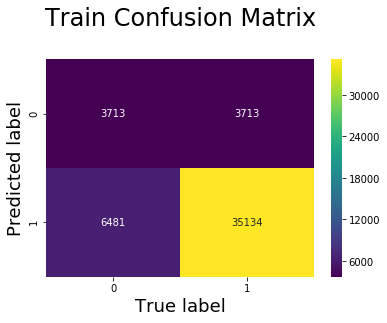

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold -0.869


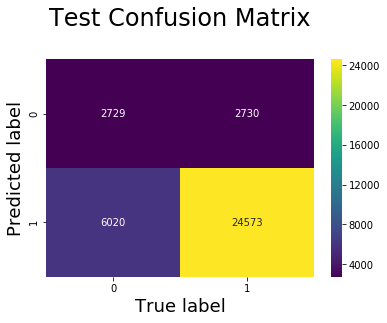

In [83]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## Set 4: categorical, numerical features + project_title(TFIDF AVG W2V)+ preprocessed_essay (TFIDF AVG W2V)

<a id='set4'></a>

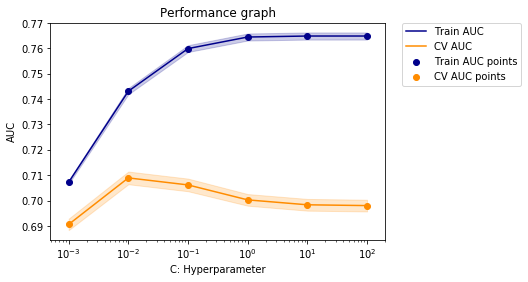

Wall time: 31min 26s


In [90]:
%%time

#Citation:
#This code is copied from here: https://stackoverflow.com/a/48803361/4084039

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model_tfidfavgw2v = LogisticRegression(random_state=0, class_weight='balanced')

#to plot the graph properly I used logspace. 
#The below code (-3, 2, 6) means 10^-3 to 10^2 with 6 values, That is
#0.001, 0.01, 0.1, 1, 10, 100 -> 6 values. Default base is 10 for logspace.

param_grid = {
    
    'C': np.logspace(-3, 2, 6)
}

grid = GridSearchCV(model_tfidfavgw2v, param_grid, cv=3, scoring='roc_auc')
                    
grid.fit(X_tr, y_train)

Cs = np.logspace(-3, 2, 6)

train_auc = grid.cv_results_["mean_train_score"]
train_scores_std = grid.cv_results_["std_train_score"]
cv_auc = grid.cv_results_["mean_test_score"]
cv_scores_std = grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Performance graph')
plt.xlabel('C: Hyperparameter')
plt.ylabel('AUC')

# plot train scores
#Make a plot with log scaling on the x axis I used semilogx.

plt.semilogx(Cs, train_auc, label='Train AUC', color='darkblue')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       train_auc - train_scores_std,
                       train_auc + train_scores_std,
                       alpha=0.2,
                       color='darkblue')

plt.semilogx(Cs, cv_auc, label='CV AUC', color='darkorange')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       cv_auc - cv_scores_std,
                       cv_auc + cv_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.scatter(Cs, train_auc, label='Train AUC points', color='darkblue')
plt.scatter(Cs, cv_auc, label='CV AUC points', color='darkorange')

#Citation for plotting the legend outside the plot
#url: https://matplotlib.org/users/legend_guide.html

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [91]:
print("Best parameters: ", grid.best_params_)

Best parameters:  {'C': 0.01}


AUC of Train Data: 0.74
AUC of Test Data: 0.71


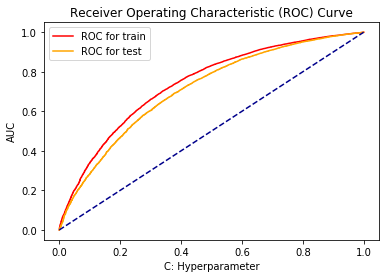

Wall time: 25.1 s


In [92]:
%%time

#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/

best_C = 0.01

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

model_tfidf = LogisticRegression(C = best_C, random_state=0, class_weight='balanced')
model_tfidf.fit(X_tr, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('C: Hyperparameter')
    plt.ylabel('AUC')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = model_tfidf.predict_log_proba(X_te)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = model_tfidf.predict_log_proba(X_tr)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.2f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.2f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [93]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold -0.887


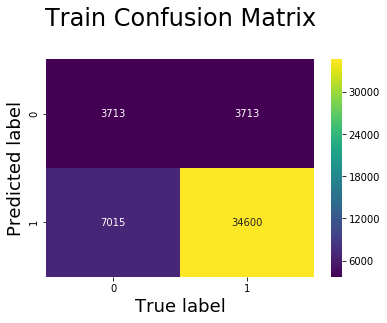

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold -0.842


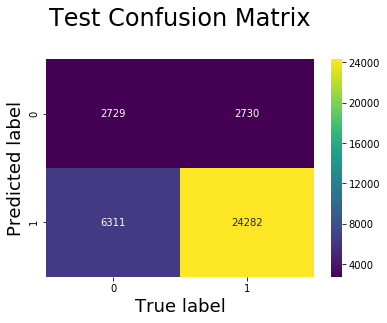

In [94]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

## Set 5: Applying Logistic Regression WITHOUT TEXT FEATURES (Essay, Project Title and Project Resource Summary). 

**Considering The Following Features:**
- school_state : categorical data
- clean_categories : categorical data
- clean_subcategories : categorical data
- project_grade_category :categorical data
- teacher_prefix : categorical data
- quantity : numerical data
- teacher_number_of_previously_posted_projects : numerical data
- price : numerical data
- sentiment score's of each of the essay : numerical data
- number of words in the title : numerical data
- number of words in the combine essays : numerical data

<a id='set5'></a>

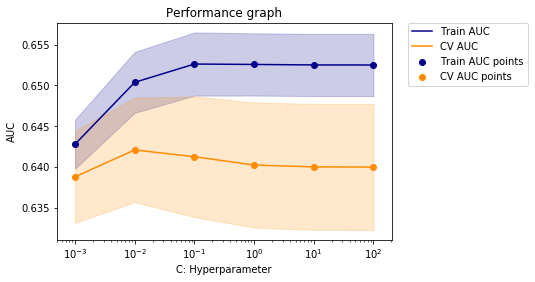

Wall time: 26.9 s


In [96]:
%%time

#Citation:
#This code is copied from here: https://stackoverflow.com/a/48803361/4084039

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model_tfidfavgw2v = LogisticRegression(random_state=0, class_weight='balanced')

#to plot the graph properly I used logspace. 
#The below code (-3, 2, 6) means 10^-3 to 10^2 with 6 values, That is
#0.001, 0.01, 0.1, 1, 10, 100 -> 6 values. Default base is 10 for logspace.

param_grid = {
    
    'C': np.logspace(-3, 2, 6)
}

grid = GridSearchCV(model_tfidfavgw2v, param_grid, cv=3, scoring='roc_auc')
                    
grid.fit(X_tr, y_train)

Cs = np.logspace(-3, 2, 6)

train_auc = grid.cv_results_["mean_train_score"]
train_scores_std = grid.cv_results_["std_train_score"]
cv_auc = grid.cv_results_["mean_test_score"]
cv_scores_std = grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Performance graph')
plt.xlabel('C: Hyperparameter')
plt.ylabel('AUC')

# plot train scores
#Make a plot with log scaling on the x axis I used semilogx.

plt.semilogx(Cs, train_auc, label='Train AUC', color='darkblue')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       train_auc - train_scores_std,
                       train_auc + train_scores_std,
                       alpha=0.2,
                       color='darkblue')

plt.semilogx(Cs, cv_auc, label='CV AUC', color='darkorange')

# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(Cs,
                       cv_auc - cv_scores_std,
                       cv_auc + cv_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.scatter(Cs, train_auc, label='Train AUC points', color='darkblue')
plt.scatter(Cs, cv_auc, label='CV AUC points', color='darkorange')

#Citation for plotting the legend outside the plot
#url: https://matplotlib.org/users/legend_guide.html

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [97]:
print("Best parameters: ", grid.best_params_)

Best parameters:  {'C': 0.01}


AUC of Train Data: 0.65
AUC of Test Data: 0.64


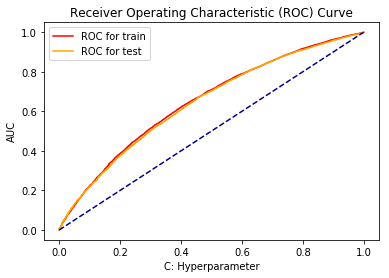

Wall time: 1.14 s


In [98]:
%%time

#Citation: plot roc auc curve
#url: https://stackabuse.com/understanding-roc-curves-with-python/

best_C = 0.01

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

model_tfidf = LogisticRegression(C = best_C, random_state=0, class_weight='balanced')
model_tfidf.fit(X_tr, y_train)

def plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr):  
    plt.plot(train_fpr, train_tpr, color='red', label='ROC for train')
    plt.plot(test_fpr, test_tpr, color='orange', label='ROC for test')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('C: Hyperparameter')
    plt.ylabel('AUC')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
y_test_pred = model_tfidf.predict_log_proba(X_te)  
y_test_pred = y_test_pred[:, 1]

y_train_pred = model_tfidf.predict_log_proba(X_tr)  
y_train_pred = y_train_pred[:, 1] 

auc_train = roc_auc_score(y_train, y_train_pred)  
print('AUC of Train Data: %.2f' % auc_train)  

auc_test = roc_auc_score(y_test, y_test_pred)  
print('AUC of Test Data: %.2f' % auc_test)  

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)  

plot_roc_curve(test_fpr, test_tpr, train_fpr, train_tpr)

In [99]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold -0.749


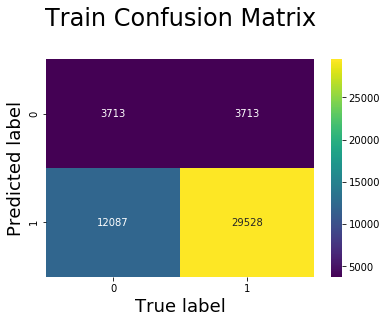

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092995 for threshold -0.742


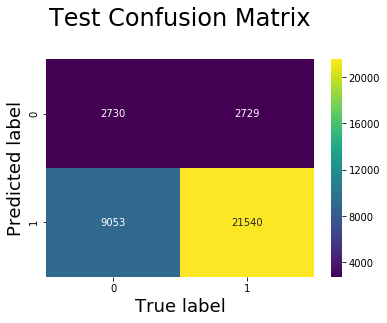

In [100]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict(y_train_pred, train_thresholds, train_fpr, train_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_train, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Train Confusion Matrix\n",size=24)
plt.show()

print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict(y_test_pred, test_thresholds, test_fpr, test_fpr))

class_names = ['negative','positive']
sns.heatmap(cm_test, annot=True, fmt='d',cmap='viridis')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Test Confusion Matrix\n",size=24)
plt.show()

# 8. Conclusion
<a id='conc'></a>

In [101]:
#Citation: 
#url: http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Index", "Vectorizer", "Model", "Hyper-parameter (C=1/\u03BB)", "AUC"]

x.add_row(["Set 1", "Bag Of Words", "Logistic Regression", 0.001, 0.73])
x.add_row(["Set 2", "TFIDF", "Logistic Regression", 0.1, 0.70])
x.add_row(["Set 3", "AVG W2V", "Logistic Regression", 0.1, 0.72])
x.add_row(["Set 4", "TFIDF AVG-W2V", "Logistic Regression", 0.01, 0.71])
x.add_row(["Set 5", "Only Categorical and Numerical Features", "Logistic Regression", 0.01, 0.64])

print(x)

+-------+-----------------------------------------+---------------------+-------------------------+------+
| Index |                Vectorizer               |        Model        | Hyper-parameter (C=1/λ) | AUC  |
+-------+-----------------------------------------+---------------------+-------------------------+------+
| Set 1 |               Bag Of Words              | Logistic Regression |          0.001          | 0.73 |
| Set 2 |                  TFIDF                  | Logistic Regression |           0.1           | 0.7  |
| Set 3 |                 AVG W2V                 | Logistic Regression |           0.1           | 0.72 |
| Set 4 |              TFIDF AVG-W2V              | Logistic Regression |           0.01          | 0.71 |
| Set 5 | Only Categorical and Numerical Features | Logistic Regression |           0.01          | 0.64 |
+-------+-----------------------------------------+---------------------+-------------------------+------+


**NOTE: Even if we dont consider text features and we consider only numerical and categorical features the AUC I got was 0.64 which is still pretty decent**